In [1]:
!pip install tensorflow==2.18.0
!pip install tensorflow-tpu==2.18.0 --find-links=https://storage.googleapis.com/libtpu-tf-releases/index.html

Looking in links: https://storage.googleapis.com/libtpu-tf-releases/index.html


Importing Libraries

In [2]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
from google.colab import drive
from tensorflow.keras import layers, models, callbacks
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Conv2D, Add, Activation, Lambda, GlobalAveragePooling2D, Reshape, Dense, Multiply
from tensorflow.keras.models import Model

/usr/local/lib/python3.11/dist-packages/jax/__init__.py:31: UserWarning: cloud_tpu_init failed: AttributeError("module 'libtpu' has no attribute 'get_library_path'")
 This a JAX bug; please report an issue at https://github.com/jax-ml/jax/issues
  _warn(f"cloud_tpu_init failed: {exc!r}\n This a JAX bug; please report "


Data Loader

In [3]:
drive.mount('/content/drive')
'''
# Paths to LR and HR folders
lr_path = '/content/drive/My Drive/Lensing Resources/Dataset/LR'
hr_path = '/content/drive/My Drive/Lensing Resources/Dataset/HR'


# Function to load images from a folder and convert them to NumPy arrays
def load_images_to_numpy(folder_path):
    images = []
    for filename in os.listdir(folder_path):
          img_path = os.path.join(folder_path, filename)
          img_array = np.load(img_path)
          images.append(img_array)
    return np.array(images)

lr_images = load_images_to_numpy(lr_path)
hr_images = load_images_to_numpy(hr_path)
'''
#This takes too much time, trying to load zip and extract here. Should be faster.

import zipfile

zip_path = '/content/drive/My Drive/Lensing Resources/3b_Dataset.zip'

# Extract the zip file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('/content/3b_Dataset')

# Load all .npy files from the extracted folder
lr_test_path = '/content/3b_Dataset/B LR Test.npy'
lr_val_path = '/content/3b_Dataset/B LR val.npy'
lr_train_path = '/content/3b_Dataset/B LR train.npy'
hr_test_path = '/content/3b_Dataset/B HR test.npy'
hr_val_path = '/content/3b_Dataset/B HR val.npy'
hr_train_path = '/content/3b_Dataset/B HR train.npy'

lr_test_images = np.load(lr_test_path)
hr_test_images = np.load(hr_test_path)
lr_train_images = np.load(lr_train_path)
hr_train_images = np.load(hr_train_path)
lr_val_images = np.load(lr_val_path)
hr_val_images = np.load(hr_val_path)

# Convert from channels-first to channels-last format
lr_test_images = np.transpose(lr_test_images, (0, 2, 3, 1))
hr_test_images = np.transpose(hr_test_images, (0, 2, 3, 1))
lr_train_images = np.transpose(lr_train_images, (0, 2, 3, 1))
hr_train_images = np.transpose(hr_train_images, (0, 2, 3, 1))
lr_val_images = np.transpose(lr_val_images, (0, 2, 3, 1))
hr_val_images = np.transpose(hr_val_images, (0, 2, 3, 1))

# resize LR from 64×64→75×75
lr_test_images  = tf.image.resize(lr_test_images,  [75, 75], method='bicubic').numpy()
lr_train_images = tf.image.resize(lr_train_images, [75, 75], method='bicubic').numpy()
lr_val_images   = tf.image.resize(lr_val_images,   [75, 75], method='bicubic').numpy()

# resize HR from 128×128→150×150
hr_test_images  = tf.image.resize(hr_test_images,  [150, 150], method='bicubic').numpy()
hr_train_images = tf.image.resize(hr_train_images, [150, 150], method='bicubic').numpy()
hr_val_images   = tf.image.resize(hr_val_images,   [150, 150], method='bicubic').numpy()


# Split into training and validation sets
X_train, X_val, y_train, y_val = lr_train_images, lr_val_images, hr_train_images, hr_val_images

# Just verifying stuff
print("LR images shape:", lr_test_images.shape)
print("HR images shape:", hr_test_images.shape)
print(f"Number of LR images: {len(lr_test_images)}")
print(f"Number of HR images: {len(hr_test_images)}")
print(f"Shape of one LR image: {lr_test_images[0].shape}")
print(f"Shape of one HR image: {hr_test_images[0].shape}")
print("Sample entry", lr_test_images[0])


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
LR images shape: (27, 75, 75, 1)
HR images shape: (27, 150, 150, 1)
Number of LR images: 27
Number of HR images: 27
Shape of one LR image: (75, 75, 1)
Shape of one HR image: (150, 150, 1)
Sample entry [[[0.08862138]
  [0.05581525]
  [0.03803296]
  ...
  [0.047352  ]
  [0.0398311 ]
  [0.03235132]]

 [[0.06973191]
  [0.05420327]
  [0.05125581]
  ...
  [0.03537383]
  [0.03695184]
  [0.05092319]]

 [[0.05120282]
  [0.06054492]
  [0.07637955]
  ...
  [0.02066625]
  [0.02027351]
  [0.04833489]]

 ...

 [[0.03380245]
  [0.04052979]
  [0.04019793]
  ...
  [0.02767885]
  [0.03222917]
  [0.04045255]]

 [[0.03955572]
  [0.04187552]
  [0.03708259]
  ...
  [0.03438776]
  [0.04369233]
  [0.04964432]]

 [[0.03955173]
  [0.0341731 ]
  [0.03482848]
  ...
  [0.04559111]
  [0.04222794]
  [0.06340541]]]


Defining RCAN

In [4]:
from tensorflow.keras.layers import Input, Conv2D, GlobalAveragePooling2D, Reshape, Dense, Multiply, Add, Layer
from tensorflow.keras.models import Model
# Define Channel Attention Module
def channel_attention(input_feature, ratio=16):
    channels = input_feature.shape[-1]
    ga_pool = GlobalAveragePooling2D()(input_feature)
    ga_pool = Reshape((1, 1, channels))(ga_pool)
    dense1 = Dense(channels // ratio, activation='relu')(ga_pool)
    dense2 = Dense(channels, activation='sigmoid')(dense1)
    return dense2

# Define Residual Channel Attention Block (RCAB)
def rcab(inputs, num_filters=64, ratio=16):
    x = Conv2D(num_filters, 3, padding='same')(inputs)
    x = tf.keras.activations.relu(x)
    x = Conv2D(num_filters, 3, padding='same')(x)
    ca = channel_attention(x, ratio)
    x = Multiply()([x, ca])
    x = Add()([x, inputs])
    return x

# Define Residual Group
def residual_group(inputs, num_rcab=5, num_filters=64, ratio=16):
    x = inputs
    for _ in range(num_rcab):
        x = rcab(x, num_filters, ratio)
    x = Conv2D(num_filters, 3, padding='same')(x)
    x = Add()([x, inputs])
    return x

# Custom Layer for Depth-to-Space (PixelShuffle)
class DepthToSpace(Layer):
    def __init__(self, scale, **kwargs):
        super(DepthToSpace, self).__init__(**kwargs)
        self.scale = scale

    def call(self, inputs):
        return tf.nn.depth_to_space(inputs, self.scale)

    def get_config(self):
        config = super(DepthToSpace, self).get_config()
        config.update({'scale': self.scale})
        return config

# Build RCAN Model
def build_rcan(input_shape=(75, 75, 1), scale=2, num_rg=5, num_rcab=5, num_filters=64, ratio=16):
    inputs = Input(shape=input_shape)
    x = Conv2D(num_filters, 3, padding='same')(inputs)
    initial = x

    # Residual Groups
    for _ in range(num_rg):
        x = residual_group(x, num_rcab, num_filters, ratio)

    x = Conv2D(num_filters, 3, padding='same')(x)
    x = Add()([x, initial])

    # Upsampling
    x = Conv2D(num_filters * (scale ** 2), 3, padding='same')(x)
    x = DepthToSpace(scale)(x)  # Use custom layer for depth_to_space
    x = Conv2D(1, 3, padding='same', activation='relu')(x)

    return Model(inputs, x)




Build, load and compile

In [5]:
# Build grayscale model
model = build_rcan()

model_path = '/content/drive/MyDrive/Lensing Resources/3a_best_checkpoint.keras'

# Load pretrained weights (with compatibility check)
try:
    model.load_weights(model_path)
except ValueError as e:
    print("Weight loading failed. Possible architecture mismatch. Error:", e)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5), loss='mean_squared_error', metrics=['mae'])

# Continue with checkpointing, training etc.
from tensorflow.keras import callbacks

checkpoint_path = '/content/drive/MyDrive/Lensing Resources/3b_checkpointing.keras'

checkpoint_cb = callbacks.ModelCheckpoint(
    checkpoint_path,
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,
    mode='min'
)


# Train the model
history = model.fit(
    lr_train_images, hr_train_images,
    validation_data=(lr_val_images, hr_val_images),
    epochs=50,
    batch_size=32
)

Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 69s 4s/step - loss: 0.0045 - mae: 0.0490 - val_loss: 0.0011 - val_mae: 0.0187
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 34s 4s/step - loss: 0.0017 - mae: 0.0226 - val_loss: 0.0015 - val_mae: 0.0220
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 33s 4s/step - loss: 0.0018 - mae: 0.0226 - val_loss: 9.0440e-04 - val_mae: 0.0177
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 33s 4s/step - loss: 0.0017 - mae: 0.0240 - val_loss: 8.6366e-04 - val_mae: 0.0180
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 34s 4s/step - loss: 0.0012 - mae: 0.0204 - val_loss: 8.0218e-04 - val_mae: 0.0169
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 33s 4s/step - loss: 0.0013 - mae: 0.0203 - val_loss: 7.9035e-04 - val_mae: 0.0167
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 33s 4s/step - loss: 0.0014 - mae: 0.0219 - val_loss: 7.4292e-04 - val_mae: 0.0166
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 34s 4s/step - loss: 0.0011 - mae: 0.0194 - val_loss: 7.2391e-04 - val_mae: 0.0163
Epoch 9/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 33s 4s/step - loss: 0.0013 -

Evaluating

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
HR shape: (27, 150, 150, 1)
SR shape: (27, 150, 150, 1)

Evaluation Metrics:
----------------------------------------
MSE:  0.004488
PSNR: 32.57 dB
SSIM: 0.7756
----------------------------------------


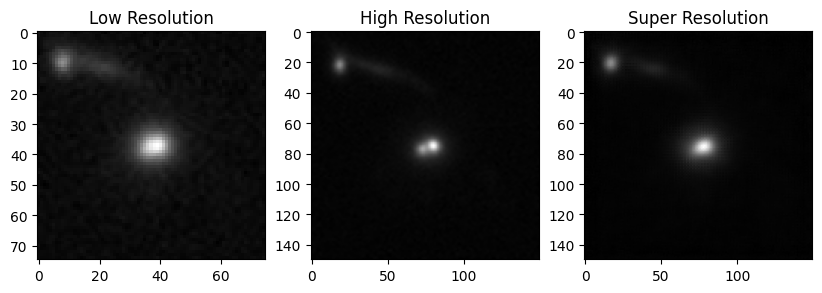

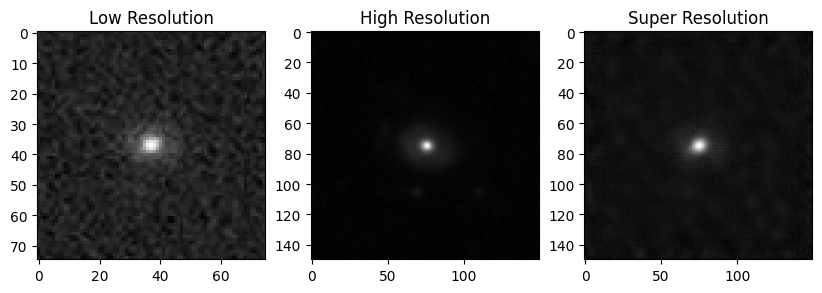

In [6]:
import tensorflow as tf
import numpy as np

def evaluate_sr(hr_true, sr_pred):
    """
    Robust evaluation function with shape validation
    Returns: MSE, PSNR, SSIM metrics
    """
    # Convert to float32 and ensure matching shapes
    hr_true = tf.cast(hr_true, tf.float32)
    sr_pred = tf.cast(sr_pred, tf.float32)

    # Validate shapes
    if hr_true.shape != sr_pred.shape:
        print(f"Shape mismatch! HR: {hr_true.shape} vs SR: {sr_pred.shape}")
        # Resize SR to match HR if needed
        sr_pred = tf.image.resize(sr_pred, hr_true.shape[1:3])

    # MSE calculation
    mse = tf.reduce_mean(tf.square(hr_true - sr_pred))

    # PSNR calculation
    psnr = tf.image.psnr(hr_true, sr_pred, max_val=1.0)

    # SSIM calculation (with fallback)
    try:
        ssim = tf.image.ssim_multiscale(
            hr_true, sr_pred,
            max_val=1.0,
            filter_size=11,
            filter_sigma=1.5,
            k1=0.01,
            k2=0.03
        )
    except (AttributeError, tf.errors.InvalidArgumentError):
        ssim = tf.image.ssim(
            hr_true, sr_pred,
            max_val=1.0,
            filter_size=11,
            filter_sigma=1.5,
            k1=0.01,
            k2=0.03
        )

    return {
        'MSE': float(mse.numpy()),
        'PSNR': float(tf.reduce_mean(psnr).numpy()),
        'SSIM': float(tf.reduce_mean(ssim).numpy())
    }

# Generate predictions
sr_test_images = model.predict(lr_test_images)

# Verify shapes before evaluation
print(f"HR shape: {hr_test_images.shape}")
print(f"SR shape: {sr_test_images.shape}")

# If shapes don't match, resize predictions
if hr_test_images.shape != sr_test_images.shape:
    print("\nResizing predictions to match ground truth...")
    sr_test_images = tf.image.resize(
        sr_test_images,
        hr_test_images.shape[1:3],  # Target height and width
        method=tf.image.ResizeMethod.BICUBIC
    )

# Clip to valid range [0, 1] and remove extra dimensions if needed
sr_test_images = np.squeeze(np.clip(sr_test_images, 0.0, 1.0))
if len(sr_test_images.shape) == 3:  # Add channel dimension if missing
    sr_test_images = np.expand_dims(sr_test_images, axis=-1)

# Run evaluation
metrics = evaluate_sr(hr_test_images, sr_test_images)

# Print results
print("\nEvaluation Metrics:")
print("-" * 40)
print(f"MSE:  {metrics['MSE']:.6f}")
print(f"PSNR: {metrics['PSNR']:.2f} dB")
print(f"SSIM: {metrics['SSIM']:.4f}")
print("-" * 40)

import matplotlib.pyplot as plt

def plot_results(lr, hr, sr, index):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 3, 1)
    plt.title('Low Resolution')
    plt.imshow(lr[index].squeeze(), cmap='gray')

    plt.subplot(1, 3, 2)
    plt.title('High Resolution')
    plt.imshow(hr[index].squeeze(), cmap='gray')

    plt.subplot(1, 3, 3)
    plt.title('Super Resolution')
    plt.imshow(sr[index].squeeze(), cmap='gray')
    plt.show()


# Plot some results
plot_results(lr_test_images, hr_test_images, sr_test_images, index=0)
plot_results(lr_test_images, hr_test_images, sr_test_images, index=1)
#print(sr_test_images[0])
#print(sr_test_images[1])